# Final Project 
## Analysis of Subway usage of Seoul using based on signal processing 

### How things go:
+ Obtain temporal Seoul subway usage data
+ Extract features using fourier transformation (or wavelet transfomr)
+ Cluster based on similarity
+ Analyze the result based on urban context

### 1. Obtain temporal Seoul subway usage data
+ Data is retrieved from [http://data.seoul.go.kr/dataList/OA-12252/S/1/datasetView.do]

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [5]:
raw_path = './Rawdata/서울시 지하철 호선별 역별 시간대별 승하차 인원 정보.csv'

raw_df = pd.read_csv(raw_path)
sample_df = raw_df[(raw_df['사용월'] < 202101) &(raw_df['사용월'] >= 202001)]

In [7]:
start_times = [str(i).zfill(2)+'시-'+str(i+1).zfill(2)+'시 '  for i in range(4, 24)]
end_times = [str(i).zfill(2)+'시-'+str(i+1).zfill(2)+'시 '  for i in range(0, 4)]

times = start_times + end_times
in_times = [i + '승차인원' for i in times]
out_times = [i + '하차인원' for i in times]

col_names = ['사용월', '호선명','지하철역']
in_cols = col_names + in_times
out_cols = col_names + out_times
in_df = sample_df[in_cols]
out_df = sample_df[out_cols]

in_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7196 entries, 2423 to 9618
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   사용월           7196 non-null   int64 
 1   호선명           7196 non-null   object
 2   지하철역          7196 non-null   object
 3   04시-05시 승차인원  7196 non-null   int64 
 4   05시-06시 승차인원  7196 non-null   int64 
 5   06시-07시 승차인원  7196 non-null   int64 
 6   07시-08시 승차인원  7196 non-null   int64 
 7   08시-09시 승차인원  7196 non-null   int64 
 8   09시-10시 승차인원  7196 non-null   int64 
 9   10시-11시 승차인원  7196 non-null   int64 
 10  11시-12시 승차인원  7196 non-null   int64 
 11  12시-13시 승차인원  7196 non-null   int64 
 12  13시-14시 승차인원  7196 non-null   int64 
 13  14시-15시 승차인원  7196 non-null   int64 
 14  15시-16시 승차인원  7196 non-null   int64 
 15  16시-17시 승차인원  7196 non-null   int64 
 16  17시-18시 승차인원  7196 non-null   int64 
 17  18시-19시 승차인원  7196 non-null   int64 
 18  19시-20시 승차인원  7196 non-null   int64 
 19  20시

In [8]:
# Create pivot table dataframe
in_pivot = pd.pivot_table(in_df, index = ['지하철역', '사용월'])
in_pivot_df = in_pivot.stack().to_frame('influx')
in_pivot_df

influx
지하철역      사용월                        
4.19민주묘지  202001 00시-01시 승차인원   123.0
                 01시-02시 승차인원     1.0
                 02시-03시 승차인원     0.0
                 03시-04시 승차인원     0.0
                 04시-05시 승차인원     1.0
...                               ...
흑석(중앙대입구) 202012 19시-20시 승차인원  6695.0
                 20시-21시 승차인원  7578.0
                 21시-22시 승차인원  4930.0
                 22시-23시 승차인원  3071.0
                 23시-24시 승차인원   835.0

[147552 rows x 1 columns]

In [9]:
# Reorganize multiindex of pivot table
row_to_col = in_pivot_df.unstack(level = -3) # Move the outermost row index to column
no_influx = row_to_col.droplevel(0, axis = 1) # Remove redundant column name "influx"
no_influx.index = no_influx.index.set_levels(no_influx.index.levels[0].astype(str), level = 0 ) # Change date int type to str for merging
no_influx.index = no_influx.index.map('_'.join) # Merge multi index into one index
in_df_cols = no_influx
print(in_df_cols)
#in_df_cols = no_influx.droplevel(0) # Remove the innermost row index "사용월"

지하철역                 4.19민주묘지      가능     가락시장  가산디지털단지       가양     가오리  \
202001_00시-01시 승차인원     123.0   129.0    752.5   1060.5    773.0   175.0   
202001_01시-02시 승차인원       1.0     0.0      6.5      3.5      4.0     3.0   
202001_02시-03시 승차인원       0.0     0.0      0.0      0.0      1.0     0.0   
202001_03시-04시 승차인원       0.0     0.0      0.0      0.0      0.0     0.0   
202001_04시-05시 승차인원       1.0   352.0     14.0    725.5     88.0     8.0   
...                       ...     ...      ...      ...      ...     ...   
202012_19시-20시 승차인원    1806.0  4542.0  10252.0  79766.5  16136.0  2133.0   
202012_20시-21시 승차인원    1747.0  3444.0   8627.0  46110.0  12013.0  1540.0   
202012_21시-22시 승차인원    1152.0  2913.0   8248.0  36926.0  10197.0  1091.0   
202012_22시-23시 승차인원     550.0  1643.0   2591.0  11808.0   3998.0   695.0   
202012_23시-24시 승차인원     209.0   529.0    721.5   3161.0    915.0   214.0   

지하철역                     가좌     가천대     가평      간석  ...       화곡  화랑대(서울여대입구)  \
202001

In [10]:
sample_cols = in_df_cols
print(sample_cols)

지하철역                 4.19민주묘지      가능     가락시장  가산디지털단지       가양     가오리  \
202001_00시-01시 승차인원     123.0   129.0    752.5   1060.5    773.0   175.0   
202001_01시-02시 승차인원       1.0     0.0      6.5      3.5      4.0     3.0   
202001_02시-03시 승차인원       0.0     0.0      0.0      0.0      1.0     0.0   
202001_03시-04시 승차인원       0.0     0.0      0.0      0.0      0.0     0.0   
202001_04시-05시 승차인원       1.0   352.0     14.0    725.5     88.0     8.0   
...                       ...     ...      ...      ...      ...     ...   
202012_19시-20시 승차인원    1806.0  4542.0  10252.0  79766.5  16136.0  2133.0   
202012_20시-21시 승차인원    1747.0  3444.0   8627.0  46110.0  12013.0  1540.0   
202012_21시-22시 승차인원    1152.0  2913.0   8248.0  36926.0  10197.0  1091.0   
202012_22시-23시 승차인원     550.0  1643.0   2591.0  11808.0   3998.0   695.0   
202012_23시-24시 승차인원     209.0   529.0    721.5   3161.0    915.0   214.0   

지하철역                     가좌     가천대     가평      간석  ...       화곡  화랑대(서울여대입구)  \
202001

In [13]:
#Visualize the time-usage graph

plt.clf()
xi = [i*24 for i in range(4)]
print(xi)
fig = plt.figure(figsize = (10, 7))
plt.rc('font', family = 'Malgun Gothic')
plt.xlabel('Month-Time')
plt.ylabel('Usage')
plt.plot(sample_cols)
plt.title('Sample Station Time-Series')
plt.tick_params(axis = 'x', labelbottom = False)
#plt.xticks = (xi, ['Jan', 'Feb', 'Mar','Apr'])
plt.legend(sample_cols.columns)
plt.show()
fig.savefig('./final_fig/copy_fig_0.png')

[0, 24, 48, 72]


<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: 

In [14]:
def norm_col(df, col):
    return col/df[col].max()
norm_cols = pd.DataFrame()
for col in sample_cols:
    norm_cols[col] = sample_cols[col] / sample_cols[col].max()

#norm_cols = sample_cols.apply(norm_col, axis = 1)
plt.clf()
'''
ax, fig = ax, plt.figure(figsize = (10, 7))
plt.rc('font', family = 'Malgun Gothic')
plt.xlabel('Month-Time')
plt.ylabel('Normalized Usage')
plt.plot(norm_cols)
plt.title('Sample Station Time-Series - Normalized')
plt.tick_params(axis = 'x', labelbottom = False)
#plt.xticks = (xi, ['Jan', 'Feb', 'Mar','Apr'])
plt.legend(norm_cols.columns, loc = 2)
plt.show()
fig.savefig('./final_fig/copy_fig_1.png')
'''

"\nax, fig = ax, plt.figure(figsize = (10, 7))\nplt.rc('font', family = 'Malgun Gothic')\nplt.xlabel('Month-Time')\nplt.ylabel('Normalized Usage')\nplt.plot(norm_cols)\nplt.title('Sample Station Time-Series - Normalized')\nplt.tick_params(axis = 'x', labelbottom = False)\n#plt.xticks = (xi, ['Jan', 'Feb', 'Mar','Apr'])\nplt.legend(norm_cols.columns, loc = 2)\nplt.show()\nfig.savefig('./final_fig/copy_fig_1.png')\n"

<Figure size 432x288 with 0 Axes>

### 2. Extract features using fourier transformation (or wavelet transfomr)

In [24]:
# Import Wavelet and decompose
import pywt
w = pywt.Wavelet('db4')
wavelet_cols = pd.DataFrame()
for k, v in enumerate(norm_cols):
    cA, cD = pywt.dwt(norm_cols[v], wavelet = w)
    cA10 = sorted(cA, reverse = True)
    cD10 = sorted(cD, reverse = True)
    ext_cA = cA10[:10]
    ext_cD = cD10[:10]
    wavelet_cols[v] = [i for i in zip(ext_cA, ext_cD)]
wavelet_cols


,4.19민주묘지,가능,가락시장,가산디지털단지,가양,가오리,가좌,가천대,가평,간석,...,화곡,화랑대(서울여대입구),화서,화전,화정,회기,회룡,회현(남대문시장),효창공원앞,흑석(중앙대입구)
0,"(1.2424718945725644, 0.08128960805062051)","(1.2998414283752824, 0.06104547094515053)","(1.1603288369997518, 0.30363306078071534)","(0.9942557274606743, 0.31698387473646533)","(1.3303192637752066, 0.10254298134148818)","(1.3481574017128701, 0.06244917368947739)","(1.258439033493213, 0.12739530892981565)","(1.109219015140052, 0.19808391645179246)","(1.0358448400194227, 0.13043738869029584)","(1.2652351449644237, 0.06085910527729727)",...,"(1.2211133273564063, 0.15269773154237046)","(1.3041473800064185, 0.043337517071617766)","(1.2362367367380784, 0.10289485937554345)","(1.3426438620754728, 0.18044601303584235)","(1.344730775178813, 0.06639626709861696)","(1.1506602621304078, 0.11685915813338671)","(1.2626364808417931, 0.05855552568945497)","(1.3527538485714024, 0.20548974559769892)","(1.0891399705038585, 0.29389212755030253)","(1.340638944412931, 0.1547043247875703)"
1,"(1.1838700954845072, 0.07346146894652884)","(1.27121370082812, 0.04516820606651083)","(1.1048945630509979, 0.29754221346937376)","(0.9537993733253715, 0.31614213326109797)","(1.3021704871195914, 0.091762295336419)","(1.3156718760360835, 0.056635828916575016)","(1.1946382009650351, 0.11025907771772572)","(1.0855465647596774, 0.16430555750771206)","(0.8670578153461822, 0.09619689879955443)","(1.2648013203079427, 0.059515537888649855)",...,"(1.1747859692945803, 0.1398530245558482)","(1.253674392649975, 0.04291449313786824)","(1.1990335283727351, 0.09405521865060404)","(1.2967642480273467, 0.13736608092317726)","(1.294916487223898, 0.06176717017362725)","(1.139010989440427, 0.09661907965157775)","(1.239880281863895, 0.05719464191034831)","(1.214738638509401, 0.19522356795025766)","(1.0846682096232287, 0.2885298517140879)","(1.1380689181323214, 0.1440630403960349)"
2,"(1.1149220151036339, 0.07013244684157358)","(1.228541066637298, 0.04462032603454424)","(1.0443473498992373, 0.28491768248834404)","(0.9351435005617038, 0.31119427951923195)","(1.2791174034329764, 0.08512196462740043)","(1.2721628554160884, 0.05335676769259575)","(1.1749516136002502, 0.09608812396943117)","(1.0643820402183761, 0.11562940372244569)","(0.7580735627108554, 0.04518503514337216)","(1.225158281324983, 0.0568954380481113)",...,"(1.1744048049497928, 0.12907531753565438)","(1.2486842928173627, 0.04267933539546631)","(1.1678788655898604, 0.08400682726225855)","(1.2910402805681436, 0.11009769889848524)","(1.2592807376187114, 0.05491559533226154)","(1.119514219832679, 0.0944038553889011)","(1.2023602865302327, 0.05118465918597514)","(1.1759400129430628, 0.1952209401929749)","(1.030748122886628, 0.2870045552552113)","(1.1134434340100694, 0.1360526460155797)"
3,"(1.0913713189825318, 0.06723815478132342)","(1.207276160640379, 0.04290155943452697)","(1.0335495264258028, 0.2739655977171894)","(0.9217671208177761, 0.2900509372650803)","(1.2278294104968293, 0.08409657469017555)","(1.2163314518259831, 0.04862218556484941)","(1.0989694966264103, 0.09168686903710388)","(1.0575093081283906, 0.10781426243586582)","(0.6537687818428594, 0.0433907674542384)","(1.1699880715193418, 0.05263001686465934)",...,"(1.1283115641786803, 0.12199919720032856)","(1.1963127576376484, 0.038050731550636686)","(1.1360499537892865, 0.08202945368519605)","(1.288898491922746, 0.09788263682873755)","(1.2286003803035757, 0.05157800107517103)","(1.0737632396040095, 0.07920615645089714)","(1.1789952005613704, 0.04862351697999147)","(1.1517821104924368, 0.1938830377033648)","(1.0192921770158467, 0.28433172960631253)","(1.0955422147308096, 0.11682358059954843)"
4,"(1.052882817529438, 0.062261168429439316)","(1.1608600005121825, 0.042514258437911664)","(0.988843768691052, 0.23679520703076135)","(0.8707106430649849, 0.27491837531189445)","(1.212295984025154, 0.08355404733430476)","(1.1987807651884093, 0.04789663108245931)","(1.0852690957644846, 0.08480977980723109)","(1.0514931954116917, 0.10598703562219655)","(0.5787524889365336, 0.0

In [25]:
#import seaborn as sns
plt.rc('font', family = 'Malgun Gothic')

fig1 = plt.figure(figsize = (10, 7))
plt.xlabel('cA(Hi-pass filter coeff)')
plt.ylabel('cD(Low-pass filter coeff')
plt.title('Top 10 Wavelet Transformation Coefficients')
#plt.legend(wavelet_cols.columns)
for v in wavelet_cols:
    temp = list(wavelet_cols[v])
    cA, cD = zip(*temp)
    plt.scatter(x = cA, y = cD)
    plt.annotate(v, (max(cA), max(cD)), size = 10)
plt.show()
fig1.savefig('./Final_fig/copy_fig_2.png')

KeyboardInterrupt: 

### 3.Cluster based on similarity

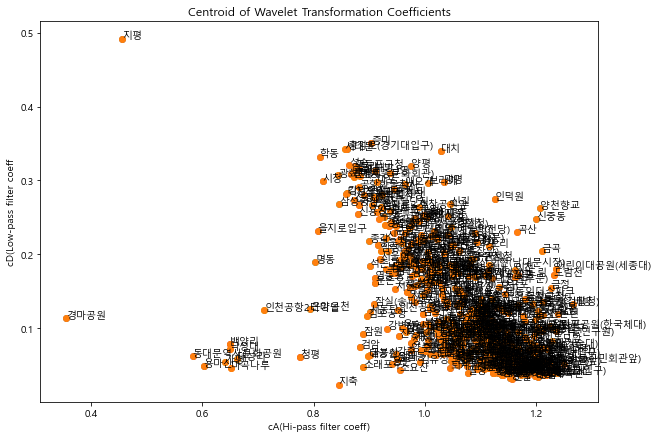

In [77]:
def get_cent(col):
    n = len(col)
    temp = list(col)
    x, y = zip(*temp)
    cent_x = sum(x)/n
    cent_y = sum(y)/n
    return (cent_x, cent_y)
cent_cols = pd.DataFrame()

fig2 = plt.figure(figsize = (10, 7))
plt.xlabel('cA(Hi-pass filter coeff)')
plt.ylabel('cD(Low-pass filter coeff')
plt.title('Centroid of Wavelet Transformation Coefficients')
for v in wavelet_cols:
    cent_cols[v] = get_cent(wavelet_cols[v])
    plt.scatter(cent_cols[v].iloc[0], cent_cols[v].iloc[1])
    #plt.annotate(v, (cent_cols[v].iloc[0], cent_cols[v].iloc[1]), size = 10)
plt.scatter(cent_cols.iloc[0], cent_cols.iloc[1])
plt.show()
fig2.savefig('./Final_fig/copy_fig_3.png')

In [72]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import numpy as np
drop_cent_cols = cent_cols.dropna(axis = 1)
np_cols = drop_cent_cols.T.to_numpy()
num_cluster = 10
kmeans = KMeans(n_clusters = num_cluster, random_state = 0).fit(np_cols)
labeled = pd.DataFrame(kmeans.labels_, index = drop_cent_cols.columns, columns = ['label'])
'''
DBSCAN_ = DBSCAN(min_samples = num_cluster).fit(np_cols)
labeled = pd.DataFrame(DBSCAN_.labels_, index = cent_cols.columns, columns = ['label'])
BotUp = AgglomerativeClustering(n_clusters = num_cluster).fit(np_cols)
labeled = pd.DataFrame(BotUp.labels_, index = cent_cols.columns, columns = ['label'])
'''
#cent_cols.T
labeled_cols = cent_cols.append(pd.DataFrame(labeled).T).T
labeled_cols.columns = ['cA', 'cD', 'label']
labeled_cols

,cA,cD,label
4.19민주묘지,1.075965,0.061797,0.0
가능,1.175044,0.041502,4.0
가락시장,1.000774,0.251545,1.0
가산디지털단지,0.882133,0.267454,2.0
가양,1.181865,0.084652,4.0
...,...,...,...
회기,1.054459,0.077957,6.0
회룡,1.134492,0.048140,4.0
회현(남대문시장),1.115914,0.185558,5.0
효창공원앞,0.989327,0.264046,1.0


In [68]:
cent_cols

,4.19민주묘지,가능,가락시장,가산디지털단지,가양,가오리,가좌,가천대,가평,간석,...,화곡,화랑대(서울여대입구),화서,화전,화정,회기,회룡,회현(남대문시장),효창공원앞,흑석(중앙대입구)
0,1.075965,1.175044,1.000774,0.882133,1.181865,1.193471,1.074436,1.018415,0.640061,1.132514,...,1.090875,1.153334,1.095978,1.129821,1.185701,1.054459,1.134492,1.115914,0.989327,1.092396
1,0.061797,0.041502,0.251545,0.267454,0.084652,0.043828,0.087357,0.120461,0.053971,0.049124,...,0.120602,0.038773,0.083100,0.103850,0.050710,0.077957,0.048140,0.185558,0.264046,0.116917


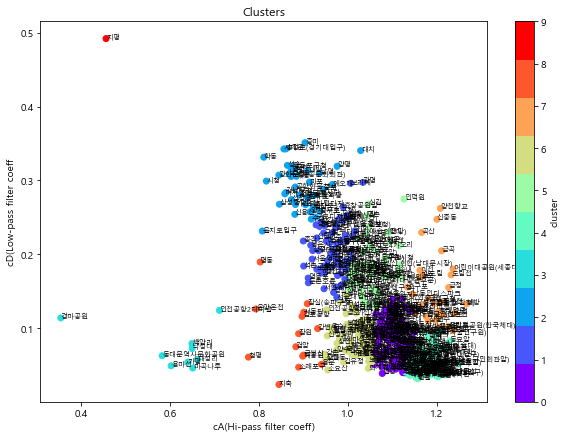

In [80]:
plt.rc('font', family = 'Malgun Gothic')
fig3 = plt.figure(figsize = (10, 7))
plt.xlabel('cA(Hi-pass filter coeff)')
plt.ylabel('cD(Low-pass filter coeff')
plt.title('Clusters')
plt.scatter(x = 'cA', y = 'cD',data = labeled_cols, c = 'label', cmap = plt.cm.get_cmap('rainbow', num_cluster))

for i, name in enumerate(labeled_cols.index):
    plt.annotate(name, (labeled_cols.loc[name]['cA'], labeled_cols.loc[name]['cD']), size = 7)
plt.colorbar(label = 'cluster')
plt.show()
fig3.savefig('./Final_fig/copy_fig_4.png')

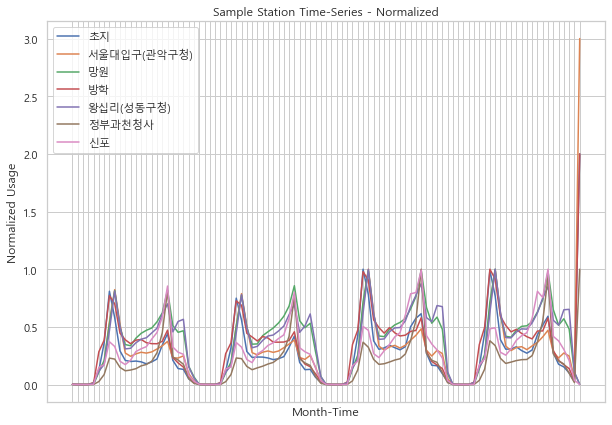

In [432]:
#plt.clf()
'''
ax, fig = ax, plt.figure(figsize = (10, 7))
plt.rc('font', family = 'Malgun Gothic')
plt.xlabel('Month-Time')
plt.ylabel('Normalized Usage')
plt.plot(norm_cols)
plt.title('Sample Station Time-Series - Normalized')
plt.tick_params(axis = 'x', labelbottom = False)
#plt.xticks = (xi, ['Jan', 'Feb', 'Mar','Apr'])
plt.legend(norm_cols.columns, loc = 2)
plt.show()
fig.savefig('./final_fig/fig_1.png')
'''

labeled_norm = norm_cols.append(pd.DataFrame(labeled).T)
labeled_norm.tail()

ax, fig = ax, plt.figure(figsize = (10, 7))
plt.rc('font', family = 'Malgun Gothic')
plt.xlabel('Month-Time')
plt.ylabel('Normalized Usage')
plt.plot(labeled_norm)
plt.title('Sample Station Time-Series - Normalized')
plt.tick_params(axis = 'x', labelbottom = False)
plt.legend(labeled_norm.columns, loc = 2)
plt.show()

{0: ['4.19민주묘지', '가좌', '간석', '개롱', '거여', '고덕', '고려대(종암)', '고속터미널', '고잔', '곤지암', '공릉(서울과학기술대)', '과천', '광나루(장신대)', '광명사거리', '구리', '구산', '구일', '길동', '까치산', '까치울', '남춘천', '남태령', '녹번', '녹천', '단대오거리', '당정', '대청', '도곡', '도농', '도봉산', '도화', '독립문', '돌곶이', '동작(현충원)', '등촌', '먹골', '면목', '명일', '목동', '무악재', '문산', '미금', '미아(서울사이버대학)', '반포', '백석', '범계', '별내', '병점', '보산', '봉명', '부개', '부발', '부천종합운동장', '북한산보국문', '북한산우이', '불광', '사가정', '사평', '삼동', '삼양', '상봉(시외버스터미널)', '상월곡(한국과학기술연구원)', '새절(신사)', '서강대', '서정리', '성균관대', '성신여대입구(돈암)', '성환', '세마', '송정', '송탄', '수원', '수유(강북구청)', '신둔도예촌', '신정(은행정)', '신정네거리', '신촌', '신풍', '신흥', '안국', '안산', '야당', '양원', '양주', '여주', '연신내', '영종', '오빈', '오산', '오산대', '오이도', '운정', '원덕', '월계', '월곡(동덕여대)', '월곶', '응암', '의정부', '이촌(국립중앙박물관)', '인천', '인하대', '정릉', '제물포', '주안', '죽전', '중동', '중앙', '중앙보훈병원', '증산(명지대앞)', '창동', '천왕', '천호(풍납토성)', '청량리(서울시립대입구)', '초월', '초지', '태릉입구', '팔당', '풍산', '한강진', '한성대입구(삼선교)', '행신', '홍제', '화계', '화곡', '화서', '화전', '흑석(중앙대입구)'], 1: ['가락시장', '강남', '경복궁(정부서울청사)', '광명', '광흥

<Figure size 432x288 with 0 Axes>

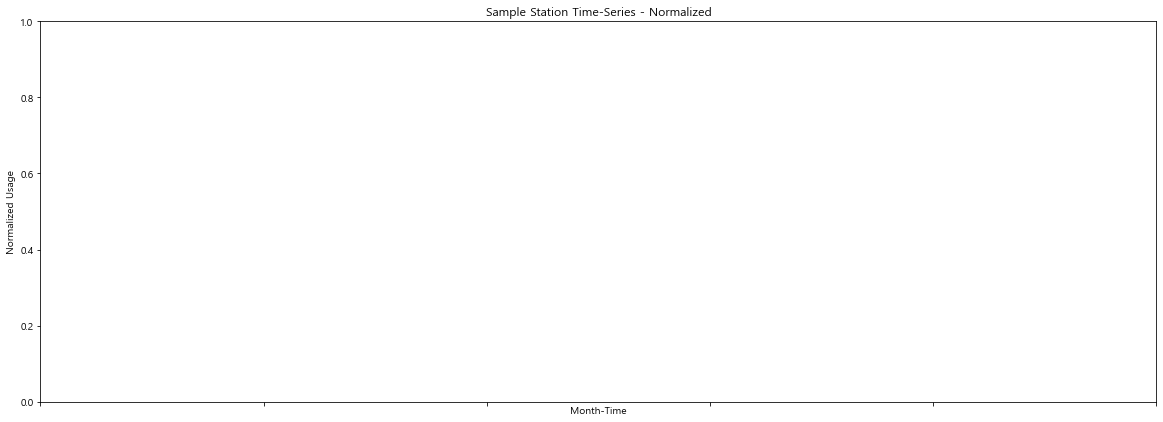

In [81]:
cluster_dict = {}
for i in range(num_cluster):
    test = labeled_cols.query('label == {}'.format(i)).index.tolist()
    cluster_dict[i] = test
print(cluster_dict)
plt.clf()
fig5, ax = plt.subplots(figsize = (20, 7))
plt.rc('font', family = 'Malgun Gothic')
plt.xlabel('Month-Time')
plt.ylabel('Normalized Usage')
plt.title('Sample Station Time-Series - Normalized')
plt.tick_params(axis = 'x', labelbottom = False)
c_list = [plt.cm.rainbow(i) for i in cluster_dict.keys()]
c_list2 = ['r','g','b','y']
#for k, v in cluster_dict.items():
    #ax.plot(norm_cols[v], color = c_list2[k])
#plt.show()
#fig5.savefig('./Final_fig/copy_fig_5.png')